In [1]:
import pymongo
from dotenv import load_dotenv
import os

import sys
sys.path.append('../src/')
from utils.preprocess_transcription import remove_ads, identify_host, insert_marker_before_host
from utils.extract_comp_guest import re_extract_comp_guest

from langchain_openai import OpenAIEmbeddings
from langchain_community.chat_models import ChatAnthropic
from langchain_openai import ChatOpenAI, OpenAI
from langchain_mistralai.chat_models import ChatMistralAI

from typing import Annotated, Dict, TypedDict, Optional

from langchain_core.messages import BaseMessage

from langchain_core.prompts import PromptTemplate
# from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser, PydanticOutputParser
import os
import pprint

from utils.company_answer_extraction import retrieve, grade_documents, generate, transform_query, decide_to_generate

from langgraph.graph import END, StateGraph
load_dotenv()


/Users/leowalker/anaconda3/envs/hibt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string
        retries: An optional integer representing the number of retries (default: 0)
        document_count: An optional integer representing the document count (default: 0)
        company: A string representing the company
    """
    keys: Dict[str, any]
    retries: Optional[int] = 1
    doc_pull_limit: Optional[int] = 4

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
# workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

NameError: name 'TypedDict' is not defined

In [3]:
client = pymongo.MongoClient(os.getenv('mdb_uri'))
DB_NAME = "hibt_prod_db"
COLLECTION_NAME = "hibt_prod_collection"
ATLAS_VECTOR_SEARCH_INDEX_NAME = "vector_index"
MONGODB_COLLECTION = client[DB_NAME][COLLECTION_NAME]
MONGODB_ANSWER_COLLECTION = client[DB_NAME]["hibt_answer_collection"]

In [16]:
### This was for a smaller test of the code without having it loop through 248 companies.

# # each mongodb document has a key called "company" I would like to get 15 unique company names from the collection

# companies = MONGODB_COLLECTION.aggregate([
#     {"$sample": {"size": 5}},
#     {"$group": {"_id": "$company"}},
#     {"$project": {"_id": 0, "company": "$_id"}},
#     {"$limit": 15}
# ])
# companies = [company["company"] for company in companies]


# company_answers = {}
# # create remaining_keys as company for company in companies if its not in company_answer.keys()
# # remaining_keys = [company for company in companies if company not in company_answers.keys()]

# for company in companies:
#     inputs = {
#         "keys": {
#             "company": company,
#             "question": """
#             How much of your success do you think is because of luck and, and how much because of Either a hardworking skill.
#             """
#         },
#         "doc_pull_limit": 4,
#         "retries": 1,
#     }

#     answer = app.invoke(inputs)
#     company_answers[company] = answer['keys']['generation'].answer

# print(company_answers)


In [ ]:
# Get all of the unique company names in our mongodb collection.

companies = MONGODB_COLLECTION.aggregate([
    {"$group": {"_id": "$company"}},
    {"$project": {"_id": 0, "company": "$_id"}},
])
companies = [company["company"] for company in companies]

In [11]:
import json
import os
from tqdm.notebook import tqdm

# Function to save company answers to a file
def save_company_answers(data, filepath="../answers/company_answers.json"):
    with open(filepath, "w") as f:
        json.dump(data, f)

# Load existing data if available
company_answers = {}
filepath = "../answers/company_answers.json"
if os.path.exists(filepath):
    with open(filepath, "r") as f:
        company_answers = json.load(f)

for i, company in enumerate(tqdm(companies, desc="Processing companies")):
    if company in company_answers:
        continue  # Skip if already processed

    inputs = {
        "keys": {
            "company": company,
            "question": """
            How much of your success do you think is because of luck, and how much because of either hardworking skill?
            """
        },
        "doc_pull_limit": 4,
        "retries": 1,
    }

    try:
        answer = app.invoke(inputs)
        company_answers[company] = answer['keys']['generation'].answer
        if (i + 1) % 10 == 0:  # Print every 10 companies
            print(f"{i + 1}: Processed {company} with generation: {answer['keys']['generation'].answer[:100]}...")  # Print a snippet of the generation
        save_company_answers(company_answers)  # Save after each successful company processing
    except Exception as e:
        print(f"Error processing {company}: {e}")
        company_answers[company] = {"error": str(e)}
        save_company_answers(company_answers)  # Save the state including errors

# Final save, in case it wasn't triggered in the loop
save_company_answers(company_answers)

Processing companies:   0%|          | 0/248 [00:00<?, ?it/s]

10: Processed Atlassian with generation: I think you need both. Like, I really believe that you make your own luck to some extent. And so you...
20: Processed Etsy with generation: Yeah, such a great question. How much of it is under my control, which is my own hard work, and how ...
30: Processed McBride Sisters Wine (Part 2 of 2) with generation: I would say 99% of it is our hard work and intelligence and then there's a small percentage that I t...
40: Processed Waymo with generation: Question/Answer not found...
50: Processed Happy Family Organics with generation: I don't see how you can answer that without saying both. You know, I think number one. I think I am ...
60: Processed Priority Bicycles with generation: I think it, it's all hard work. We have been in the right place at the right time, but we wouldn't h...
70: Processed Khan Academy with generation: It's all all of the above. I mean, it's you know one person can call it luck. One person might call ...
80: Processed Vita Co

In [2]:
# # read in the dictionary and turn it into a table where the first column is the key and the second is the values
# import pandas as pd
# df = pd.DataFrame(company_answers.items(), columns=["company", "answer"])
# df

In [2]:
# read in "../answers/company_answers.json") into a pandas dataframe
import json
import pandas as pd

with open("../answers/company_answers.json", "r") as f:
    company_answers = json.load(f)

df = pd.DataFrame(company_answers.items(), columns=["company", "answer"])

In [3]:
df

,company,answer
0,The Tetris Company,"Oh, it's, it's all because of hard work. I mea..."
1,Crate & Barrel,"Well, the lucky part was our timing and was ju..."
2,Brooklinen,"There's a mix. I mean, I think it's lucky. The..."
3,Eleven Madison Park,I think so much of random chance and luck. I'v...
4,Aviator Nation,"I think that it's, it's really the hard work. ..."
...,...,...
243,Alamo Drafthouse Cinema,I would say that a lot of it has to do with ha...
244,Aurora,Question/Answer not found
245,Impossible Foods,I think the most important thing is I feel lik...
246,inov-8,I think it is a combination of them both becau...


In [4]:
from pydantic.v1 import BaseModel, Field

class AnswerGrade(BaseModel):
    summary: str
    luck: int
    work: int
    people: int


In [5]:
summary_score_prompt = """
    You are a summary and topic extraction expert. You are provided with answers to a question "How much of your success do you think is because of luck, and how much because of either hardworking skill?" 
    and you are to summarize the answers focusing on their underlying topics. 

    You will also be required to score the answer based on three metrics:
    - luck: How much of the success is attributed to luck, 0 being no luck and 10 being all luck.
    - work: How much of the success is attributed to skill and hard work, 0 being no skill and 10 being all skill and hard work.
    - people: How much of the success is attributed to the people around them or their network, 0 being no people and 10 being all people.

    Here is the guests answer:

    {answer}

    You are to respond in json format with the following structure:
    {response_template}
"""

In [57]:
def sum_grade_answer(answer: str) -> AnswerGrade:
    """
    This function takes in a string and returns a QuestionAnswer object with the summary and scores.
    """

    output_parser = PydanticOutputParser(pydantic_object=AnswerGrade)
    # Create the prompt
    prompt_template = PromptTemplate.from_template(template= summary_score_prompt)
    prompt_template.input_variables = {"answer": answer}
    prompt_template.partial_variables = {"response_template": output_parser.get_format_instructions()}
    # Create the chat model
    llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

    # Chain
    rag_chain = prompt_template | llm | output_parser

    # Generate the summary and scores
    generation = rag_chain.invoke({"answer": answer})
    print(answer)
    print()
    print(generation)
    return generation

In [58]:
# df["answer"][0]

In [60]:
output = sum_grade_answer(df["answer"][2])

There's a mix. I mean, I think it's lucky. There's some things that are crazy lucky like that rich ran into Neil Blumenthal and he's suggested that, you know, he look at things like that's crazy luck, but a lot of it was working really hard and talking to people and trying to get the word out like day in day out pound the pavement. So that part I can't say this lucky was just, you know, just doing it.

summary='The success is attributed to a mix of luck, hard work, and networking.' luck=4 work=6 people=4


In [61]:
# I need to loop through the dataframe and apply the function to each answer with each answer place summary, luck, work, and people into their own column in the pandas dataframe

df["scores"] = df["answer"].apply(lambda x: sum_grade_answer(x))



Oh, it's, it's all because of hard work. I mean, this is not like I rolled a dice and something happened. I like to compare it to surfing. I used to, I used to surf and basically, you know, some day a giant wave is gonna come and If, you haven't surfed the small waves and worked and worked and paddled and paddled and, and, and learned all that stuff. Then when that big wave comes up, you're just gonna get killed. The, the, the, you need to know how to surf before you, you know, and you can't read about it in a book. This is, you've gotta get out in the water and try stuff.

summary='Success is attributed mainly to hard work and preparation, similar to surfing where one needs to practice and learn before encountering big challenges.' luck=0 work=10 people=0
Well, the lucky part was our timing and was just that the appropriate time to be going to Europe to find new contemporary design and tabletop and Furniture and Things. I think it was a talent of attracting people and making make them

In [63]:
# parse df["scores"] into 4 columns and add them to the dataframe
df["summary"] = df["scores"].apply(lambda x: x.summary)
df["luck"] = df["scores"].apply(lambda x: x.luck)
df["work"] = df["scores"].apply(lambda x: x.work)
df["people"] = df["scores"].apply(lambda x: x.people)

In [73]:
#drop the scores column
df = df.drop(columns="scores")

In [75]:
#I need to save down the df into ../answers/

df.to_csv("../answers/company_answers.csv", index=False)

Text(0, 0.5, 'Frequency')

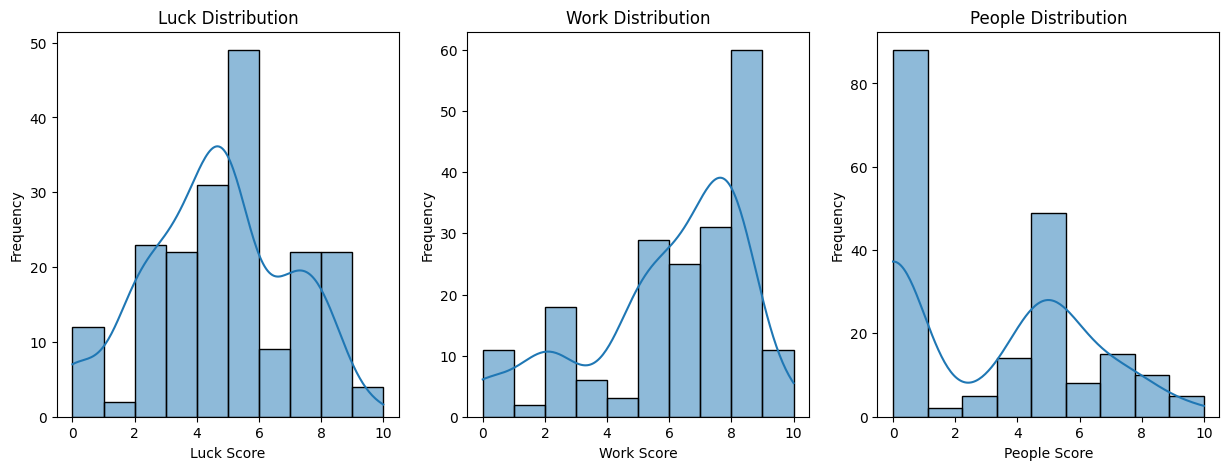

In [72]:
filtered_df = df[df["answer"] != "Question/Answer not found"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(filtered_df["luck"], kde=True, ax=ax[0])
ax[0].set_title("Luck Distribution")
ax[0].set_xlabel("Luck Score")
ax[0].set_ylabel("Frequency")

sns.histplot(filtered_df["work"], kde=True, ax=ax[1])
ax[1].set_title("Work Distribution")
ax[1].set_xlabel("Work Score")
ax[1].set_ylabel("Frequency")

sns.histplot(filtered_df["people"], kde=True, ax=ax[2])
ax[2].set_title("People Distribution")
ax[2].set_xlabel("People Score")
ax[2].set_ylabel("Frequency")
